In [70]:
%matplotlib inline

In [71]:
import numpy as np
import MDAnalysis 
import matplotlib.pyplot as plt

import tqdm

# Top matters

* beyond scope

In [72]:
import f90nml
nml = f90nml.read('./example_data/LJCFS-CYL-NH_1_RAD_4.0_TEMP_0.72871_DENS_0.65_NPART_4000_.params_used')

# basic run parameters
dt = nml['run_params_nml']['deltat']
npart = nml['state_point_nml']['nparttot']
density= np.round(nml['state_point_nml']['density'],2)
temperature = nml['state_point_nml']['temperature']
region = np.array(nml['box_nml']['char_region'])

# info about dump
sample_dic = {}
for k in ['nbuff', 'nval', 'step']:
    sample_dic[k] = nml['xtc_nml']['xtc'][k]
    
for k in ['overlapEndStart','overlap','iparams','style']:
    sample_dic[k] = nml['xtc_nml']['xtc']['sampler'][k]

# rename 
for new,old in [('style_params','iparams')]:
    sample_dic[new]= sample_dic[old]
    del sample_dic[old]

    
ntypes=1
atom_types=[0]*4000

In [73]:
#Need a topology file
import pymdanal.topology as top
top.creat_psf_namd('top.psf',atom_names=['A']*4000)

# lets calculate some properties from an md trajectory

 * Need trajectory file (XTC, DMD, etc)
 * Need  topology file (pdb, psf, lammps)

In [74]:
TRJ = './example_data/LJCFS-CYL-NH_1_RAD_4.0_TEMP_0.72871_DENS_0.65_NPART_4000_.xtc'
TOP = 'top.psf'

### create "Universe"

In [75]:
import MDAnalysis 

In [76]:
u = MDAnalysis.Universe(TOP,TRJ,convert_units=False)

In [77]:
u.trajectory[2]

< Timestep 2 with unit cell dimensions [   8.            8.          122.42658997   90.           90.           90.        ] >

In [78]:
print 'step'
print u.trajectory[0]
print 'time'
print u.trajectory[0].time
print 'meta'
print u.trajectory[0].data
print 'pos'
print u.trajectory[0].positions

step
< Timestep 0 with unit cell dimensions [   8.            8.          122.42658997   90.           90.           90.        ] >
time
0.00999999977648
meta
{'step': 4, 'dt': 0.009999999776482582, 'time': 0.009999999776482582}
pos
[[ -1.6680001    1.51800013  43.45200348]
 [  3.16600013   0.32300001 -10.53900051]
 [  1.26600003   0.60800004 -55.6740036 ]
 ..., 
 [  0.098       -3.09600019  47.74000168]
 [ -2.99300003  -0.62800002 -13.63400078]
 [  2.40300012  -1.97100008  32.43400192]]


# Static properties

In [79]:
import pymdanal.StaticProp as SP
import pymdanal.Utils as mdUtils

## density profile $\rho(r)$ and static structure factor $S(k)$

In [80]:
profile = SP.profile_cyl(step=1,limit=100, box=region,ntypes=1,atom_types=atom_types,rmax=4.0,dr=0.05)
sk = SP.StatStrucFac(step=1, limit=100, box=region, ntypes=1, atom_types=atom_types,pairs='all')

In [81]:
i = 0
for step, traj in tqdm.tqdm(mdUtils.trajectory_delta_generator(1000, u.trajectory),leave=True, total=100,miniters=1):

    profile.EvalAll(step, x=traj.positions, box=traj.dimensions[:3])
    sk.EvalAll(step, x=traj.positions, box=traj.dimensions[:3])
    i += 1
    if i>100:
        break

 99%|█████████▉| 99/100 [00:02<00:00, 45.28it/s]


In [82]:
ds_p = profile.to_Dataset()
ds_s = sk.to_Dataset()

In [83]:
ds_p

<xarray.Dataset>
Dimensions:  (r: 80, rec: 1, type: 1)
Coordinates:
  * r        (r) float32 0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 ...
  * type     (type) int64 0
  * rec      (rec) int64 0
Data variables:
    density  (rec, type, r) float32 2.53761 2.58961 2.20065 1.91212 1.6224 ...
Attributes:
    npart_per_type: [4000]
    type_map: [0]
    Region: [   8.            8.          122.42659301]

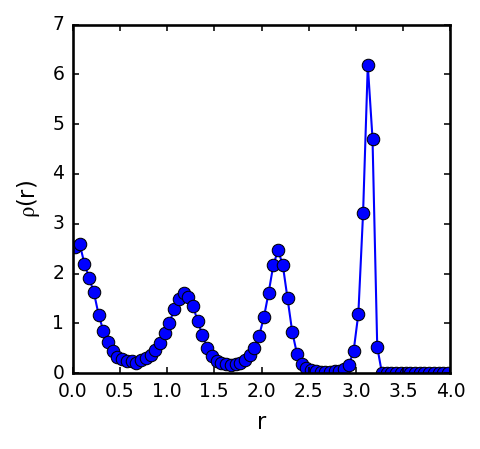

In [84]:
plt.plot(ds_p.r, ds_p.density.sel(type=0,rec=0),'o-')
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')

In [85]:
ds_s

<xarray.Dataset>
Dimensions:  (dim: 3, k: 500, pair: 1, rec: 1)
Coordinates:
  * pair     (pair) <U3 u'0:0'
  * dim      (dim) |S1 'x' 'y' 'z'
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * rec      (rec) int64 0
Data variables:
    S        (rec, pair, dim, k) float32 292.111 77.2689 33.7188 17.5433 ...
    kvals    (k, dim) float32 0.785398 0.785398 0.0513221 1.5708 1.5708 ...
Attributes:
    nk0: [1 1 1]
    pair_type_map: [(0, 0)]
    npart_per_type: [4000]
    Region: [   8.            8.          122.42659301]
    dnk: [1 1 1]

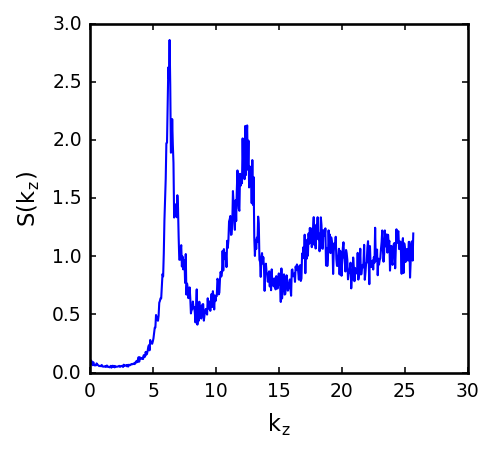

In [86]:
plt.plot(ds_s.kvals.sel(dim='z'), ds_s.S.sel(rec=0,pair='0:0', dim='z'),'-')
plt.xlabel(r'$k_z$')
plt.ylabel(r'$S(k_z)$')

# dynamic properties

In [87]:
import pymdanal.TimeProp2 as TP

In [88]:
s = sample_dic.copy()
s['nbuff']=2

In [89]:
diffusion = TP.DiffusionMSD(s,limit=1,dt=dt,npart=npart,ntypes=1,atom_types=atom_types,volume=region.prod(),
                            temperature=temperature)

sisf = TP.Sisf(s,limit=1, dt=dt, npart=npart, ntypes=1, atom_types=atom_types, box=region,nk=20, dnk=10)



In [90]:
for step, traj, rTrue in tqdm.tqdm(
    mdUtils.trajectory_generator(u.trajectory,unwrap=True,box=region,periodic=True),
    total=5200,leave=True):
    
    diffusion.EvalAll(step,x=rTrue)
    sisf.EvalAll(step, x=traj.positions)
    #PlogD.EvalAll(step,x=rTrue)
    if step>4000004:
        break

 99%|█████████▊| 5123/5200 [00:05<00:00, 1197.47it/s]


In [91]:
# get dataset
ds_d = diffusion.to_Dataset()
ds_F = sisf.to_Dataset()


# Diffusion

In [92]:
ds_d

<xarray.Dataset>
Dimensions:         (dim: 3, rec: 3, time: 147, type: 1)
Coordinates:
  * dim             (dim) |S1 'x' 'y' 'z'
  * type            (type) int64 0
  * time            (time) float64 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 ...
  * rec             (rec) int64 0 1 2
Data variables:
    MSD_COLLECTIVE  (rec, type, dim, time) float32 0.0 0.00158921 0.00323088 ...
    MSD             (rec, type, dim, time) float32 0.0 0.00382743 0.00759915 ...
Attributes:
    volume: 7835.30195295
    npart_per_type: [4000]
    type_map: [0]
    temperature: 0.72871

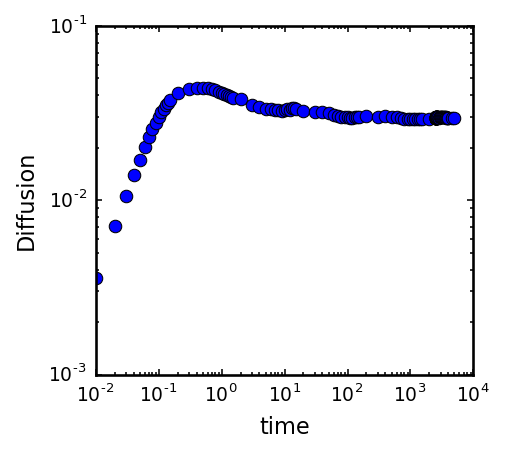

In [93]:
plt.loglog(ds_d.time, ds_d.MSD.sel(type=0,dim='z').mean('rec'),'o')
plt.xlabel('time')
plt.ylabel('Diffusion')

# Sisf

In [94]:
ds_F

<xarray.Dataset>
Dimensions:  (dim: 3, k: 20, rec: 3, time: 147, type: 1)
Coordinates:
  * dim      (dim) |S1 'x' 'y' 'z'
  * type     (type) int64 0
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * rec      (rec) int64 0 1 2
Data variables:
    SISF     (rec, type, dim, k, time) float32 1.0 0.999988 0.999916 ...
    kvals    (k, dim) float64 0.7854 0.7854 0.05132 8.639 8.639 0.5645 16.49 ...
Attributes:
    nk0: [1 1 1]
    Region: [   8.            8.          122.42659301]
    type_map: [0]
    npart_per_type: [4000]
    dnk: [10 10 10]

In [95]:
t = ds_F.sel(k=12, dim='z', type=0).mean('rec')
t

<xarray.Dataset>
Dimensions:  (time: 147)
Coordinates:
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 ...
Data variables:
    SISF     (time) float32 1.0 0.99862 0.994523 0.987823 0.978752 0.967571 ...
    kvals    float64 6.21

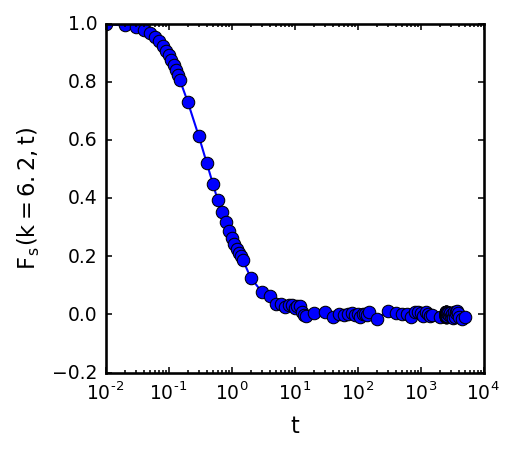

In [96]:
plt.plot(t.time, t.SISF,'o-')
plt.xscale('log')

plt.xlabel(r'$t$')

plt.ylabel(r'$F_s(k={:.2g},t)$'.format(t.kvals.values[()]))

# thermal conductivity

In [97]:
import xarray as xr

In [98]:
props = xr.open_dataset('./example_data/LJCFS-CYL-NH_1_RAD_4.0_TEMP_0.72871_DENS_0.65_NPART_4000_.props.nc')
props['val'] = ['val','ave','var']

In [99]:
props

<xarray.Dataset>
Dimensions:               (bounds: 2, dim: 3, nwall: 2, pv: 6, rec: 4100, val: 3)
Coordinates:
  * bounds                (bounds) int64 0 1
  * dim                   (dim) int64 0 1 2
  * nwall                 (nwall) int64 0 1
  * pv                    (pv) int64 0 1 2 3 4 5
  * rec                   (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * val                   (val) |S3 'val' 'ave' 'var'
Data variables:
    step                  (rec) int32 5000 10000 15000 20000 25000 30000 ...
    e_n                   (rec, val) float64 -7.176 -7.129 0.0003566 -7.105 ...
    ke_n                  (rec, val) float64 1.071 1.092 0.000227 1.102 ...
    pe_n                  (rec, val) float64 -8.247 -8.222 0.0001515 -8.207 ...
    hamiltonian_n         (rec, val) float64 -6.849 -6.849 1.136e-10 -6.849 ...
    pv_n_tot              (rec, pv, val) float64 -0.25 -0.07568 0.06173 ...
    pv_n_mom              (rec, pv, val) float64 0.7169 0.7263 0.000344 ...
    pv_n_vi

In [100]:
energy_vector = props.energy_vector
energy_vector

<xarray.DataArray 'energy_vector' (rec: 4100, dim: 3, val: 3)>
array([[[  1.84151345e+02,   7.57422133e+01,   7.99756597e+05],
        [ -9.62131916e+02,   4.72728518e+01,   7.96851915e+05],
        [ -4.82181601e+02,   1.55529833e+00,   1.72745440e+05]],

       [[ -2.83623493e+02,   1.42612197e+01,   8.69365110e+05],
        [ -9.86311762e+02,   6.54336872e+01,   8.09239971e+05],
        [ -3.61985244e+02,   6.71757422e+01,   1.62582636e+05]],

       [[  8.79000243e+02,   8.86294303e+00,   8.62352049e+05],
        [  7.43685159e+02,   3.94263746e+01,   8.50601229e+05],
        [  3.67635948e+02,   3.13894044e+01,   1.43570400e+05]],

       ..., 
       [[ -6.81486588e+02,  -4.09365806e+01,   8.41267863e+05],
        [ -1.21696140e+02,  -5.05248026e+01,   8.24075544e+05],
        [ -4.99781723e+02,   4.59033131e+01,   1.53462867e+05]],

       [[ -1.11524386e+03,  -8.44890889e+01,   7.88836461e+05],
        [ -1.44279424e+03,  -1.88175899e+01,   9.30302723e+05],
        [ -3.1553494

# need integral:

$$
\lambda = \lim_{t\rightarrow \infty} MSD(t)/(2t)
$$

where

$$
MSD(t) = \frac{V}{3 T^2} \int \vec{S}(t) dt
$$

In [101]:
# get integral
int_energy_vec = TP.get_cumint_xr(energy_vector.sel(val='ave'),energy_vector.sel(val='val'), props.step[0].values, props.deltaT)

In [102]:
TC = TP.ThermCondTot(dict(nbuff=100, nval=200, overlapEndStart=True, step=props.step[0].values[()], style='fac',style_params=1.2),
                100,dt=props.deltaT,volume=region.prod(),temperature=temperature)

In [103]:
for step, EV in tqdm.tqdm(zip(props.step.values, int_energy_vec.values),total=len(props.rec),leave=True):
    TC.EvalAll(step, EV)

100%|██████████| 4100/4100 [00:01<00:00, 3183.10it/s]


In [104]:
ds = TC.to_Dataset()

In [105]:
ds

<xarray.Dataset>
Dimensions:  (dim: 3, rec: 19, time: 29)
Coordinates:
  * dim      (dim) |S1 'x' 'y' 'z'
  * time     (time) float64 0.0 12.5 25.0 37.5 50.0 62.5 75.0 87.5 100.0 ...
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
Data variables:
    MSD      (rec, dim, time) float32 0.0 5.80496 5.3287 4.21759 4.7111 ...
Attributes:
    Volume: 7835.30195295
    temperature: 0.72871

In [106]:
m = ds.MSD.sel(dim='z').mean('rec')
s = ds.MSD.sel(dim='z').std('rec')

<Container object of 3 artists>

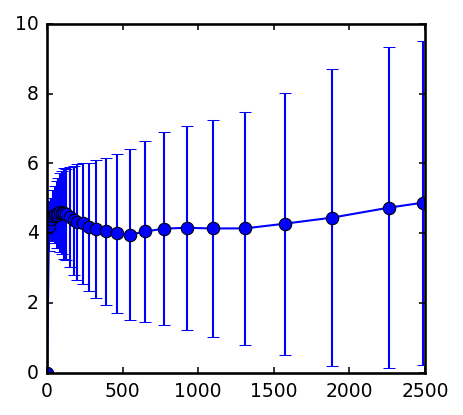

In [107]:
plt.errorbar(ds.time, m, yerr=s,marker='o')
#plt.xscale('log')
#plt.xlim(1e-1,None)
